# Machine learning with  Blob Databases

In this tutorial, you will learn how to extract feature data from Blob Databases and then use that feature data to train a simple Machine Learning model to classify blobs into "Small", "Big", and "Double" categories.

Blob Databases are a convenient and efficient way of storing blob data from VideometerLab. Using the Videometer Python toolbox, you can read both feature, class and image data from a Blob Database.

### Prerequisites
Ensure you have the required libraries installed:

```bash
pip install videometer scikit-learn
```

Download the example Blob Database from

## 1. Import Libraries and Load Data

First, we import the necessary libraries and initialize the `BlobDatabase` with our example file.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from videometer.BlobDatabase import BlobDatabase

# Initialize the database connection
# Ensure 'example.blobdb' is in the same directory or provide the full path
db_path = r"PATH TO BLOB DATABASE"
db = BlobDatabase(db_path)

The Blob Database only reads data as necessary, so loading it will not be slow even if the database contains many thousands of blobs.

Next we will obtain our dataset. For this, we use `get_data_frame()` to extract all data as a Pandas data frame. There is always at least three columns: "Blob id", "Reference Class" and "Predicted Classs". Additionally, there is a column for each feature defined on a blob.

In [2]:
# Load all data into a DataFrame
df = db.get_data_frame()

# Display the first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (26, 14)


,Blob id,Predicted Class,Reference Class,Area (mm2) (Unknown),CIEAllComponents1 [0] (Unknown),CIEAllComponents1 [1] (Unknown),CIEAllComponents1 [2] (Unknown),Compactness Circle (Unknown),Compactness Ellipse (Unknown),Compactness Ellipse (WasherClassifier),Length (AreaClassifier),Length (mm) (Unknown),RatioWidthLength (Unknown),Width (mm) (Unknown)
0,09a6de45-6a79-400a-b5b9-46eb9c0313f4,Big,Small,25.655399,63.041122,-1.827536,2.783885,0.595876,0.597541,0.597541,6.66,6.66,0.995495,6.630000
1,0acbef84-1fd0-4260-8fa7-a452b23360b4,Big,"Big, Large",50.067898,61.553123,-1.369771,5.687212,0.745534,0.750886,0.750886,8.73,8.73,0.989691,8.639999
2,0cb6908e-6c93-428f-ae5a-0b4ea1b7213b,Big,Small,25.682400,67.187492,-1.450442,2.700871,0.599102,0.599618,0.599618,6.66,6.66,1.000000,6.660000
3,17e971aa-479d-42ab-9257-4278607bdfb3,Big,Small,25.695898,50.767330,1.201868,5.627045,0.595054,0.598728,0.598728,6.69,6.69,0.995516,6.660000
4,1a880c03-14d8-48e0-8e01-f4dde1329b51,Big,Small,25.650898,62.928368,-1.448776,3.832102,0.599588,0.600192,0.600192,6.63,6.63,0.995475,6.600000


## 2. Preprocess the Data

The database returns a DataFrame containing IDs, labels, and features. We need to:
1. Select the specific feature columns we want to use.
2. Select the classes to use for training
3. Separate the **Features (X)** from the **Target (y)**.
4. Drop any rows where the target class is missing.

In [ ]:
# Define the feature columns based on the database schema
feature_cols = [
    'Area (mm2) (Unknown)', 
    'Compactness Circle (Unknown)', 
    'Compactness Ellipse (Unknown)', 
    'Length (mm) (Unknown)', 
    'RatioWidthLength (Unknown)', 
    'Width (mm) (Unknown)'
]

# Filter the DataFrame
# We use 'Reference Class' as our ground truth label
targets = ['Small', 'Large', 'Double']

# 2. Split strings into lists and "explode" them so each class gets its own row
# This creates a Series where the index is duplicated for multi-label blobs
exploded = df['Reference Class'].str.split(', ').explode()

# 3. Filter using fast vectorized check
# This removes any rows that are NOT in your target list
filtered = exploded[exploded.isin(targets)]

# 4. Group by the original index (level=0) and join the remaining classes back together
# This automatically drops any blobs that ended up with NO classes
cleaned_labels = filtered.groupby(level=0).agg(', '.join)

# 5. Filter the original DataFrame to keep only the matching blobs
# and update their labels with the cleaned versions
df_clean = df.loc[cleaned_labels.index].copy()
df_clean['Reference Class'] = cleaned_labels

# Split into X (features) and y (target)
X = df_clean[feature_cols]
y = df_clean['Reference Class']

print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) distribution:\n{y.value_counts()}")

Features (X) shape: (26, 6)
Labels (y) distribution:
Reference Class
Small          18
Big, Large      5
Big, Double     3
Name: count, dtype: int64


## 3. Split Data into Training and Testing Sets

We split the data to train the model on 80% of the data and validate it on the remaining 20%.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures class balance is maintained in the split
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 20
Testing samples: 6


## 4. Train a Random Forest Classifier

We use a Random Forest classifier, which is robust for tabular feature data.

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
clf.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


## 5. Evaluate the Model

We verify the performance using a classification report and a confusion matrix to see how well it distinguishes between "Small", "Big", and "Double".

Classification Report:
              precision    recall  f1-score   support

 Big, Double       1.00      1.00      1.00         1
  Big, Large       1.00      1.00      1.00         1
       Small       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



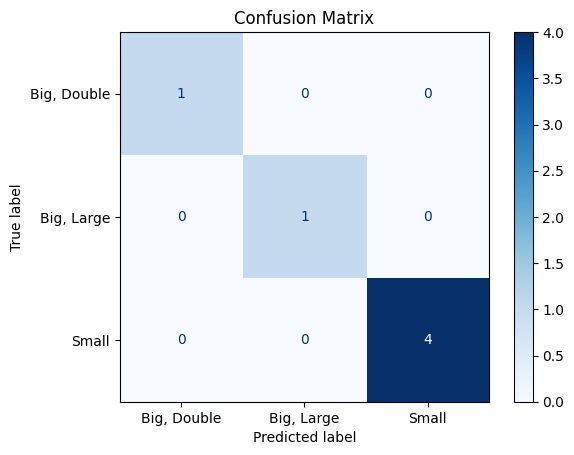

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Make predictions
y_pred = clf.predict(X_test)

# Print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## 6. Feature Importance

Finally, we visualize which physical features were most important for the classification.

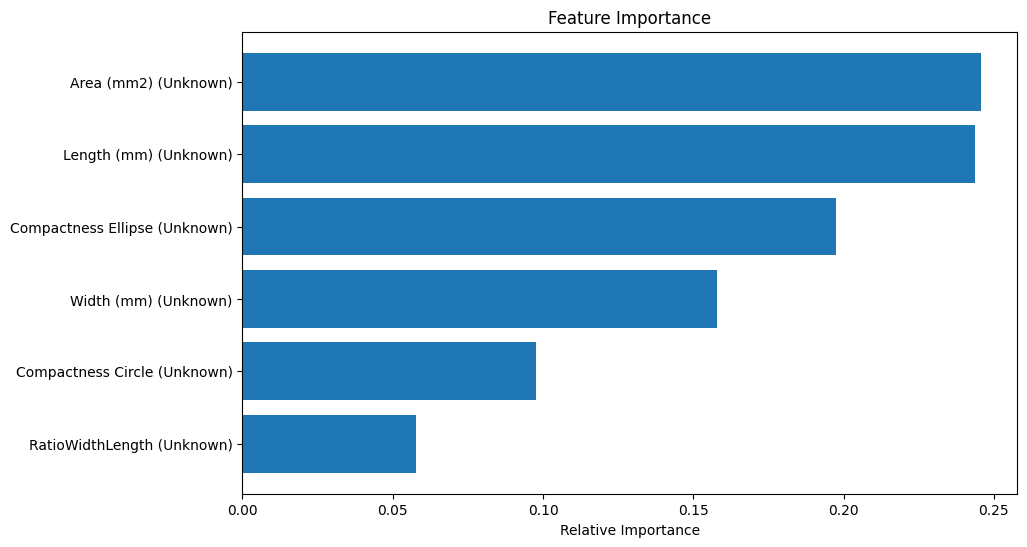

In [6]:
# Get feature importances
importances = clf.feature_importances_

# Sort for better visualization
indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
plt.show()